### Task 4: 
Forecast for the next six months, after the last date of the data, the sum of visitors of all the restaurants and validate the accuracy of your forecast. You can solve this question using the tool that you prefer.

In [60]:
# Importing packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima


# Reading CSV's

date_info_df = pd.read_csv("Data/date_info.csv")
restaurant_visitors_df = pd.read_csv("Data/restaurants_visitors.csv")
store_info_df = pd.read_csv("Data/store_info.csv")

In [131]:
# Converting 'visit_datetime' to datetime
restaurant_visitors_df['visit_datetime'] = pd.to_datetime(restaurant_visitors_df['visit_datetime'], format='%d/%m/%Y %H:%M')

# Extracting the date
restaurant_visitors_df["visit_date"] = restaurant_visitors_df["visit_datetime"].dt.date

# Converting 'visit_date' to datetime and set as index
restaurant_visitors_df['visit_date'] = pd.to_datetime(restaurant_visitors_df['visit_date'])
restaurant_visitors_df.set_index('visit_date', inplace=True)

# Grouping by month and sum 'reserve_visitors'
weekly_visitors = restaurant_visitors_df['reserve_visitors'].resample('W').sum()

# Converting Series to DataFrame and reset the index
weekly_visitors_df = weekly_visitors.to_frame().reset_index()

In [151]:
# Weeklyvisitors
weekly_visitors_df

,visit_date,reserve_visitors
0,2016-01-03,56
1,2016-01-10,150
2,2016-01-17,230
3,2016-01-24,266
4,2016-01-31,204
...,...,...
70,2017-05-07,130
71,2017-05-14,170
72,2017-05-21,78
73,2017-05-28,63


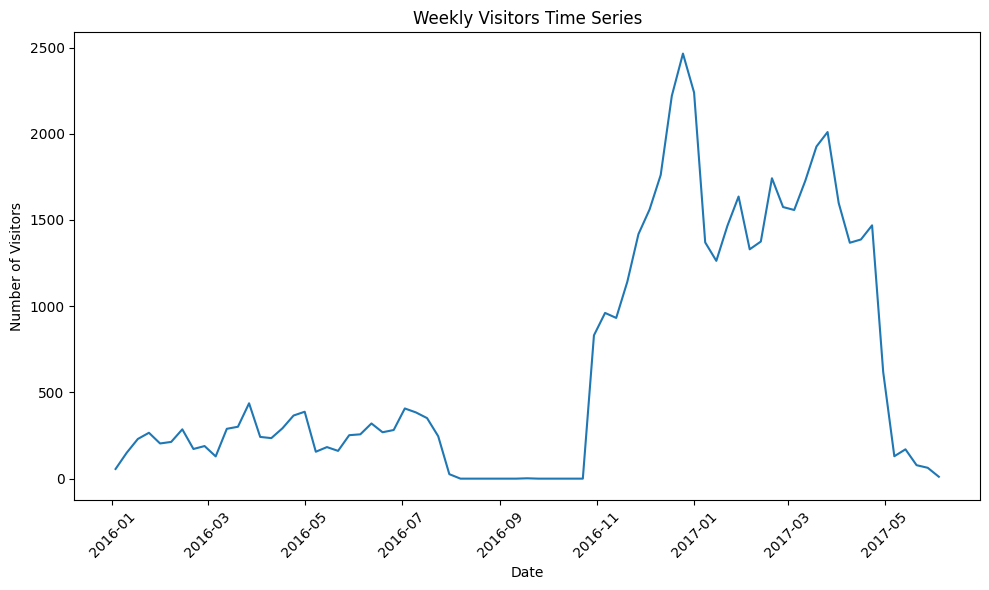

In [133]:

plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_visitors_df, x='visit_date', y='reserve_visitors')
plt.title('Weekly Visitors Time Series')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [149]:

split_point = int(len(weekly_visitors_df) * 0.8)

# Split the data
train_data = weekly_visitors_df[:split_point]
test_data = weekly_visitors_df[split_point:]

# Prepare the data
y_train = train_data['reserve_visitors']
y_test = test_data['reserve_visitors']
X_train = np.arange(len(y_train)).reshape(-1, 1)
X_test = np.arange(len(y_train), len(y_train) + len(y_test)).reshape(-1, 1)

In [150]:
# Trying out a variety of models

# Exponential Smoothing Model 
model_exp_smoothing_adj = ExponentialSmoothing(y_train, trend='add')
model_exp_smoothing_fit_adj = model_exp_smoothing_adj.fit(optimized=True)
y_pred_exp_smoothing_adj = model_exp_smoothing_fit_adj.forecast(steps=len(y_test))

# ARIMA Model
auto_arima_model = auto_arima(y_train, seasonal=False, error_action='ignore', suppress_warnings=True)
y_pred_arima = auto_arima_model.predict(n_periods=len(y_test))
rmse_arima = mean_squared_error(y_test, y_pred_arima, squared=False)

# Simple Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# Calculate Mean Squared Error for each model
mse_exp_smoothing = mean_squared_error(y_test, y_pred_exp_smoothing_adj)
mse_arima = mean_squared_error(y_test, y_pred_arima)
mse_lr = mean_squared_error(y_test, y_pred_lr)             # Validating the models with RMSE.

np.sqrt(mse_exp_smoothing), np.sqrt(mse_arima), np.sqrt(mse_lr)

# The model that has the lower RMSE is a simple linear regression.

(1206.5730616366716, 966.9702879761027, 963.3820374305274)

In [180]:
# Creating future indices for the next 24 weeks
start_index_for_forecast = len(y_train) + len(y_test)
future_indices = np.arange(start_index_for_forecast, start_index_for_forecast + 24).reshape(-1, 1)

# Forecasting using the Linear Regression model for the next 24 weeks
forecast = model_lr.predict(future_indices)
forecast

array([1725.04432713, 1750.70317681, 1776.36202649, 1802.02087617,
       1827.67972585, 1853.33857553, 1878.99742521, 1904.65627489,
       1930.31512457, 1955.97397425, 1981.63282393, 2007.29167361,
       2032.95052329, 2058.60937297, 2084.26822265, 2109.92707233,
       2135.58592202, 2161.2447717 , 2186.90362138, 2212.56247106,
       2238.22132074, 2263.88017042, 2289.5390201 , 2315.19786978])

C:\Users\guill\AppData\Local\Temp\ipykernel_7604\2432707712.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



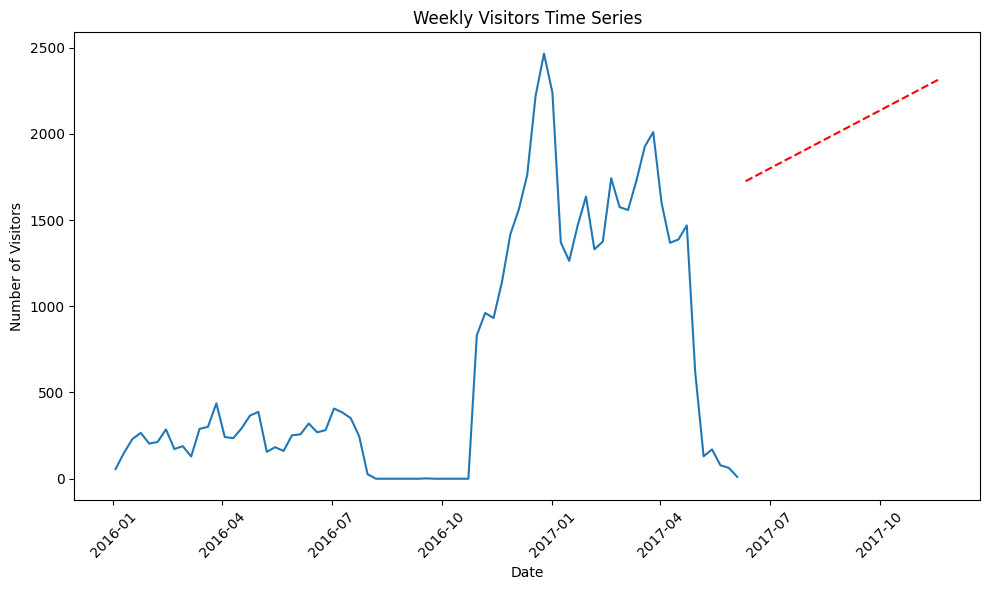

In [189]:
# Generating dates for the forecast
# Assuming the data is weekly and the forecast starts the week after the last date in 'weekly_visitors_df'
last_date_in_data = pd.to_datetime(weekly_visitors_df["visit_date"][-1])
forecast_start_date = last_date_in_data + pd.DateOffset(weeks=1)
forecast_dates = pd.date_range(start=forecast_start_date, periods=24, freq='W')

# Creating the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_visitors_df, x='visit_date', y='reserve_visitors')
plt.plot(forecast_dates, forecast, label='Forecast', color='red', linestyle='--')
plt.title('Weekly Visitors Time Series')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()